- https://huggingface.co/Helsinki-NLP/opus-mt-ko-en
- https://huggingface.co/docs/transformers/model_doc/marian
- https://github.com/huggingface/transformers/blob/v4.33.0/src/transformers/models/marian/modeling_marian.py#L1106

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install --upgrade transformers
!pip install accelerate -U
!pip install sentencepiece
!pip install sacremoses
!pip install nltk

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from transformers import pipeline
from transformers import MarianTokenizer, MarianMTModel, MarianConfig, MarianModel
from transformers import AdamW, get_scheduler

import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# 1.데이터셋 로드

In [4]:
# 데이터 경로
path = "/content/drive/MyDrive/data/shuffled_kor_eng_concat_dataset.csv"

# 데이터 불러오기
df = pd.read_csv(path, encoding='utf-8')

df.head()

,원문,번역문
0,그들 체면이 말이 아닙니다.,They ought to be ashamed of their reputation.
1,한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.,"If Hanwha's offense doesn't improve, it's hard..."
2,"오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등...","In the offline program, creativity and charact..."
3,"행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한...","More than 100 people attended the event, inclu..."
4,이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.,They were surprised that there was an unlimite...


In [5]:
# 데이터 분할
train_df = df[:45000]   #5만개
valid_df = df[45000:49000]
test_df = df[49000:50000]

train_df.shape, valid_df.shape, test_df.shape

((45000, 2), (4000, 2), (1000, 2))

In [6]:
input_train = train_df['원문']
target_train = train_df['번역문']

input_valid = valid_df['원문']
target_valid = valid_df['번역문']

input_test = test_df['원문']
target_test = test_df['번역문']

input_train.shape, target_train.shape

((45000,), (45000,))

# 2.기존 모델 및 토크나이저 테스트

In [7]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)

In [ ]:
# 번역할 텍스트를 정의
input_text = "안녕하세요, 과연 영어로 번역이 가능한가요?"

In [ ]:
# 한글 텍스트를 토큰화하고 번역 수행
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True)
print(input_ids)

translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
print(translated_ids)

translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)

# 번역 결과 출력
print("번역 결과:", translated_text)

tensor([[ 4192,     3,  8906, 40529, 12496,    48,  5403,  7083,     7,     0]])
tensor([[65000,  3306,     2,   622,    18, 17452,   177,  2411,     7,     0]])
번역 결과: Hello. Can you translate into English?


In [ ]:
translated = model.generate(**tokenizer(input_text, return_tensors="pt", padding=True))
print(translated)

tgt_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
tgt_text

tensor([[65000,  3306,     2,   622,    18, 17452,   177,  2411,     7,     0]])


['Hello. Can you translate into English?']

# 3.기존 모델 BeLU 측정 - 10개

In [124]:
input_test = test_df['원문']
target_test = test_df['번역문']

In [ ]:
# 원본과 번역본
original_text_list = input_test[:10].tolist()      # 한글
translated_text_list = target_test[:10].tolist()   # 영어

original_text_list[:5], translated_text_list[:5]

(['대학 1학년에서는 기본적으로 여러 과목들을 배웁니다.',
  '경찰과 소방당국은 김 씨가 암벽에서 발을 헛디뎌 사고가 난 것으로 추정하고 있으며 정확한 사고 경위를 조사 중이다.',
  '나는 기술팀에 있는 챈이라고 합니다.',
  '편지 속의 그 문구는 자연스럽지 않습니다.',
  '인터넷을 통해 마음이 맞는 사람들끼리 그룹을 만들어서 한국어를 배우고, 모임을 갖고 만나면서 한국어로 대화를 나누는 사람들도 증가하고 있다.'],
 ['When you are a freshman, you basically learn various subjects.',
  'Police and fire authorities suspect that Kim lost his footing on the rock wall and caused the accident, and are investigating the exact circumstances.',
  "I'm Chan from the technical department.",
  'That words in the letter are not natural.',
  'There are also increasing numbers of people who learn Korean by forming a group of people that they like on the internet, and have a meeting and talk in Korean.'])

In [ ]:
# 한글 텍스트를 토큰화하고 번역된 결과를 리스트에 저장하는 테스트
modeling_text_list = []

for korean in original_text_list:
    input_ids = tokenizer.encode(korean, return_tensors="pt", max_length=1024, truncation=True)
    translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    modeling_text_list.append(translated_text)

modeling_text_list[:5]

['In my freshman year in college, I basically learn a lot of subjects.',
 "Police and fire departments estimate Mr. Kim's foot has been knocked off the rock wall, and they are investigating exactly how the accident took place.",
 "I'm Chen on the tech team.",
 'That phrase in the letter is not natural.',
 'More and more people are using the Internet to create groups of right-hearted people who are learning Korean, who are meeting with the group, and talking to them in Korean.']

In [ ]:
# 문장을 토큰 리스트로 변환하는 함수
def num_to_char(input_ids):
    text = []
    vocab = tokenizer.get_vocab()
    for number in input_ids:
        if number in [0, 65000]:
            continue  # number가 0, 65000이면 다음 반복으로 넘어감
        char = next(key for key, value in vocab.items() if value == number)
        text.append(char)
    return text


# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"
# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

num_sentences = 10  # 10개로 test함으로 범위를 10으로 지정
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = num_to_char(tokenizer(translated_text_list[i])['input_ids'])
    candidate_tokens = num_to_char(tokenizer(modeling_text_list[i])['input_ids'])

    # BLEU Score 계산
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 | 원본 번역본: {translated_text_list[i]}")
        print(f"{i}번째 | 모델 번역본: {modeling_text_list[i]}")
        print(f"{i}번째 | 원본 번역본 토큰: {reference_tokens}")
        print(f"{i}번째 | 모델 번역본 토큰: {candidate_tokens}")
        print(f"{i}번째 | BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

0번째 | 원본 번역본: When you are a freshman, you basically learn various subjects.
0번째 | 모델 번역본: In my freshman year in college, I basically learn a lot of subjects.
0번째 | 원본 번역본 토큰: ['▁W', 'h', 'en', '▁you', '▁are', '▁a', '▁f', 're', 'sh', 'man', ',', '▁you', '▁b', 'as', 'ic', 'ally', '▁l', 'ear', 'n', '▁', 'va', 'ri', 'ous', '▁s', 'ub', 'ject', 's', '.']
0번째 | 모델 번역본 토큰: ['▁In', '▁my', '▁f', 're', 'sh', 'man', '▁y', 'ear', '▁in', '▁c', 'ol', 'le', 'ge', ',', '▁I', '▁b', 'as', 'ic', 'ally', '▁l', 'ear', 'n', '▁a', '▁l', 'ot', '▁of', '▁s', 'ub', 'ject', 's', '.']
0번째 | BLEU 점수: 0.5806451612903226
----------------------------------------------------------------------------------------------------
1번째 | 원본 번역본: Police and fire authorities suspect that Kim lost his footing on the rock wall and caused the accident, and are investigating the exact circumstances.
1번째 | 모델 번역본: Police and fire departments estimate Mr. Kim's foot has been knocked off the rock wall, and they are investigating exactly

# 4.Dataset, DataLoader

### 4-1. Dataset 정의

In [8]:
# 데이터 로딩 및 전처리를 위한 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, source_df, target_df, tokenizer, max_length=128):
        self.source_sentences = source_df.reset_index().drop('index', axis=1).values.tolist()
        self.target_sentences = target_df.reset_index().drop('index', axis=1).values.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        source_text = self.source_sentences[idx][0]
        target_text = self.target_sentences[idx][0]

        # 토큰화 및 패딩
        source_tokens = self.tokenizer(source_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)
        target_tokens = self.tokenizer(target_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)

        # 아래 부분을 수정하여 input_ids를 반환하도록 재정의
        return {'input_ids': torch.tensor(source_tokens['input_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(source_tokens['attention_mask'], dtype=torch.long),
                'decoder_input_ids': torch.tensor(target_tokens['input_ids'], dtype=torch.long)}

In [9]:
# train_df.head()

,원문,번역문
0,그들 체면이 말이 아닙니다.,They ought to be ashamed of their reputation.
1,한화의 공격력이 나아지지 않는다면 지난해와 같은 성적은 기대하기 어렵다.,"If Hanwha's offense doesn't improve, it's hard..."
2,"오프라인 프로그램에서는 창의적 사고기법과 문제해결방법, 의사소통 능력과 협업능력 등...","In the offline program, creativity and charact..."
3,"행사에는 유주현 대한건설협회 회장을 비롯해 최영묵 건설공제조합 이사장, 임영헌 대한...","More than 100 people attended the event, inclu..."
4,이들은 데이터 무제한 요금제가 있다는 것에 놀랐다.,They were surprised that there was an unlimite...


In [102]:
# source_sentences = train_df['원문'].reset_index().drop('index', axis = 1).values.tolist()
# print(source_sentences)

# source_text = source_sentences[1][0]
# print(source_text)

source_tokens = tokenizer(source_text, add_special_tokens=True, max_length=128, padding="max_length", truncation=True)
print(source_tokens) # {"input_ids" : [...], "attention_mask" : [...]}

# print(torch.tensor([source_tokens['input_ids'], source_tokens['attention_mask']], dtype=torch.long))

{'input_ids': [54, 633, 53, 4519, 16000, 9661, 5386, 11788, 33163, 195, 532, 12832, 92, 5321, 820, 9, 23211, 2, 0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [105]:
# target_sentences = train_df['번역문'].reset_index().drop('index', axis = 1).values.tolist()
# print(target_sentences)

# target_text = target_sentences[0][0]
# print(target_text)

target_tokens = tokenizer(target_text, add_special_tokens=True, max_length=128, padding="max_length", truncation=True)
print(target_tokens)  # {"input_ids" : [...], "attention_mask" : [...]}

# print(torch.tensor([target_tokens['input_ids'], target_tokens['attention_mask']], dtype=torch.long))

{'input_ids': [180, 9, 20747, 49, 5, 31, 9, 19231, 2135, 194, 6, 4, 2959, 1640, 1438, 4885, 1664, 2, 0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
# 토크나이저 및 vocab 로드
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 데이터셋 생성
train_dataset = CustomDataset(input_train, target_train, tokenizer)
valid_dataset = CustomDataset(input_valid, target_valid, tokenizer)
test_dataset = CustomDataset(input_test, target_test, tokenizer)

train_dataset, valid_dataset, test_dataset

(<__main__.CustomDataset at 0x79600fb62950>,
 <__main__.CustomDataset at 0x79603b280370>)

In [26]:
special_tokens = tokenizer.special_tokens_map
print(special_tokens)

{'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}


In [18]:
vocab = tokenizer.get_vocab()
vocab

{'</s>': 0,
 '<unk>': 1,
 '.': 2,
 ',': 3,
 '▁the': 4,
 '▁to': 5,
 '▁of': 6,
 '?': 7,
 '▁and': 8,
 '▁': 9,
 's': 10,
 '▁a': 11,
 "'": 12,
 '▁in': 13,
 '▁들': 14,
 '▁that': 15,
 '▁I': 16,
 '▁”': 17,
 '▁you': 18,
 '▁“': 19,
 '▁is': 20,
 '▁이': 21,
 '▁-': 22,
 '▁을': 23,
 '▁it': 24,
 '▁의': 25,
 '▁for': 26,
 '▁은': 27,
 '!': 28,
 '▁에': 29,
 '▁’': 30,
 '▁be': 31,
 '▁‘': 32,
 '▁with': 33,
 '▁not': 34,
 '▁was': 35,
 '▁have': 36,
 '▁we': 37,
 '▁are': 38,
 '▁on': 39,
 '▁가': 40,
 '▁는': 41,
 '▁this': 42,
 '▁를': 43,
 '▁그': 44,
 '▁—': 45,
 ':': 46,
 '’': 47,
 '이': 48,
 't': 49,
 '▁as': 50,
 '을': 51,
 ')': 52,
 '의': 53,
 '▁한': 54,
 '는': 55,
 '▁they': 56,
 '▁The': 57,
 '▁(': 58,
 '▁he': 59,
 '▁his': 60,
 '▁will': 61,
 '가': 62,
 '▁God': 63,
 '에': 64,
 '▁from': 65,
 '...': 66,
 '▁can': 67,
 '▁by': 68,
 '▁your': 69,
 '▁And': 70,
 '▁what': 71,
 '▁do': 72,
 '▁all': 73,
 '▁에서': 74,
 '▁me': 75,
 '▁으로': 76,
 '▁their': 77,
 '▁or': 78,
 '를': 79,
 '▁one': 80,
 '▁who': 81,
 '▁them': 82,
 '▁at': 83,
 '▁my': 84,
 '고':

In [ ]:
# vocab['</s>'], vocab['<unk>'],  vocab['<pad>']

In [ ]:
# len(train_dataset)

In [ ]:
# train_dataset[0]

### 4-2. DataLoader

In [10]:
batch_size = 100

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_dl, valid_dl

(<torch.utils.data.dataloader.DataLoader at 0x79600fb625f0>,
 <torch.utils.data.dataloader.DataLoader at 0x79600fb63f10>)

In [ ]:
# next(iter(dataloader))

In [21]:
# next(iter(dataloader))['input_ids'].shape

NameError: ignored

In [128]:
batch = next(iter(train_dl))
batch

{'input_ids': tensor([[  968,  6769,   225,  ..., 65000, 65000, 65000],
         [   54,   633,    53,  ..., 65000, 65000, 65000],
         [  515,   954, 12361,  ..., 65000, 65000, 65000],
         ...,
         [  777,   814,   603,  ..., 65000, 65000, 65000],
         [  754,  5553, 19865,  ..., 65000, 65000, 65000],
         [ 3895, 17520,  5875,  ..., 65000, 65000, 65000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_input_ids': tensor([[  180,     9, 20747,  ..., 65000, 65000, 65000],
         [   16,  1931,  1753,  ..., 65000, 65000, 65000],
         [  138,     4,     9,  ..., 65000, 65000, 65000],
         ...,
         [   16,  1640,  5838,  ..., 65000, 65000, 65000],
         [   91,    35,    11,  ..., 65000, 65000, 65000],
         [ 1080,  3405,  1252,  ..., 65000,

In [ ]:
# len(train_dl)

In [ ]:
# input_ids = batch['input_ids']
# input_ids, input_ids.shape

In [ ]:
# translated_ids = model.generate(input_ids, num_beams=4, max_length=150, early_stopping=True)
# print(translated_ids), len(translated_ids)

In [ ]:
# for i in range(len(translated_ids)):
#     translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
#     print(f"{i+1}번째 번역 결과:", translated_text)

In [ ]:
# batch['decoder_input_ids']

In [ ]:
# for i in range(len(batch['decoder_input_ids'])):
#     translated_text = tokenizer.decode(batch['decoder_input_ids'][i], skip_special_tokens=True)
#     print(f"{i+1}번째 정답 결과:", translated_text)

In [ ]:
# model(input_ids=batch['input_ids'], decoder_input_ids=batch['decoder_input_ids'])

In [ ]:
# config = MarianConfig.from_pretrained(model_name)
# config.decoder_layers = 1

# new_model = MarianMTModel.from_pretrained(model_name, config=config).to(device)
# new_model

In [ ]:

# input_ids = batch['input_ids'].to(device)
# decoder_input_ids = batch['decoder_input_ids'].to(device)

# output = new_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
# output

# 5.새로운 모델 정의

In [11]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [ ]:
# class TranslationModel(nn.Module):
#     def __init__(self, pretrained_model_name = 'Helsinki-NLP/opus-mt-ko-en', num_decode_layers = 1):
#         super(TranslationModel, self).__init__()
#         # encoder-decoder 모델 가져오기
#         self.marian_model = MarianMTModel.from_pretrained(pretrained_model_name)

#         # 추가할 레이어
#         self.dropout = nn.Dropout(dropout_prob)
#         self.layer_norm = nn.LayerNorm(self.marian_model.config.hidden_size)
#         self.lm_head = self.marian_model.lm_head

#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     def forward(self, input_ids, decoder_input_ids):

#         # encoder / decoder 입력값
#         input_ids = input_ids.to(self.device)                   # encoder input
#         decoder_input_ids = decoder_input_ids.to(self.device)   # decoder input

#         # 기존 모델
#         logits = self.marian_model(input_ids=input_ids, decoder_input_ids=decoder_input_ids).logits
#         # logits = outputs.logits

#         # 추가한 레이어
#         layer_norm_shape = list(logits.size()[1:])
#         layer_norm = nn.LayerNorm(layer_norm_shape).to(self.device)

#         # Apply dropout and layer normalization
#         logits = self.dropout(logits)
#         logits = layer_norm(logits)

#         return logits

In [ ]:
# class TranslationModel(nn.Module):
#     def __init__(self, model_name = 'Helsinki-NLP/opus-mt-ko-en', num_decode_layers = 1):
#         super(TranslationModel, self).__init__()
#         self.config = MarianConfig.from_pretrained(model_name)
#         self.config.decoder_layers = num_decode_layers
#         self.marian = MarianMTModel.from_pretrained(model_name, config=self.config)

#         for param in self.marian.get_encoder().parameters():
#                 param.requires_grad = False

#     def forward(self, input_ids, decoder_input_ids):
#         result = self.marian(input_ids, decoder_input_ids)

#         return result[0]


#     def generate(self, input_ids):
#         result = self.marian(input_ids)

#         return result[0]

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 새로운 모델 생성
# new_model = TranslationModel().to(device)
# new_model

## 디코더 레이어 6 -> 1 모델

In [25]:
model_name = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)

config = MarianConfig.from_pretrained(model_name)
config.decoder_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

new_model = MarianMTModel.from_pretrained(model_name, config=config).to(device)
new_model

Some weights of the model checkpoint at Helsinki-NLP/opus-mt-ko-en were not used when initializing MarianMTModel: ['model.decoder.layers.2.final_layer_norm.bias', 'model.decoder.layers.2.fc1.bias', 'model.decoder.layers.3.self_attn.q_proj.bias', 'model.decoder.layers.3.self_attn_layer_norm.weight', 'model.decoder.layers.1.self_attn_layer_norm.weight', 'model.decoder.layers.5.self_attn_layer_norm.bias', 'model.decoder.layers.2.encoder_attn.out_proj.bias', 'model.decoder.layers.3.encoder_attn_layer_norm.bias', 'model.decoder.layers.3.self_attn.q_proj.weight', 'model.decoder.layers.4.fc2.weight', 'model.decoder.layers.4.encoder_attn.q_proj.bias', 'model.decoder.layers.3.fc2.bias', 'model.decoder.layers.5.fc1.bias', 'model.decoder.layers.4.encoder_attn.out_proj.bias', 'model.decoder.layers.3.final_layer_norm.bias', 'model.decoder.layers.1.self_attn.k_proj.bias', 'model.decoder.layers.4.self_attn_layer_norm.bias', 'model.decoder.layers.5.encoder_attn_layer_norm.weight', 'model.decoder.layer

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

# 6.모델 학습 및 검증

##6-1.모델 학습

### 6개 디코더 레이어 원래 모델

In [98]:
# 모델 정의
model_name = "Helsinki-NLP/opus-mt-ko-en"

# 토크나이저 불러오기
tokenizer = MarianTokenizer.from_pretrained(model_name)

# 모델 불러오기
model = MarianMTModel.from_pretrained(model_name)
model.config

MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-ko-en",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      65000
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 65000,
  "decoder_vocab_size": 65001,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "extra_pos_embeddings": 65001,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "m

In [32]:
config = MarianConfig.from_pretrained(model_name)
config.decoder_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

new_model = MarianMTModel.from_pretrained(model_name, config=config).to(device)
new_model.config

Some weights of the model checkpoint at Helsinki-NLP/opus-mt-ko-en were not used when initializing MarianMTModel: ['model.decoder.layers.2.final_layer_norm.bias', 'model.decoder.layers.2.fc1.bias', 'model.decoder.layers.3.self_attn.q_proj.bias', 'model.decoder.layers.3.self_attn_layer_norm.weight', 'model.decoder.layers.1.self_attn_layer_norm.weight', 'model.decoder.layers.5.self_attn_layer_norm.bias', 'model.decoder.layers.2.encoder_attn.out_proj.bias', 'model.decoder.layers.3.encoder_attn_layer_norm.bias', 'model.decoder.layers.3.self_attn.q_proj.weight', 'model.decoder.layers.4.fc2.weight', 'model.decoder.layers.4.encoder_attn.q_proj.bias', 'model.decoder.layers.3.fc2.bias', 'model.decoder.layers.5.fc1.bias', 'model.decoder.layers.4.encoder_attn.out_proj.bias', 'model.decoder.layers.3.final_layer_norm.bias', 'model.decoder.layers.1.self_attn.k_proj.bias', 'model.decoder.layers.4.self_attn_layer_norm.bias', 'model.decoder.layers.5.encoder_attn_layer_norm.weight', 'model.decoder.layer

MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-ko-en",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      65000
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 1,
  "decoder_start_token_id": 65000,
  "decoder_vocab_size": 65001,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "extra_pos_embeddings": 65001,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "m

### learning rate 줄여가며 학습시켜보기 - lr_scheduler 사용 (별로 유의미하진 않음)

In [115]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# 학습할 모델 정의
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
# StepLR 스케줄러 설정
step_size = 10  # 학습률을 조절할 주기 (에폭 단위)
gamma = 0.5     # 학습률을 감소시킬 배율

scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# 학습 루프
# encoder 파라미터 동결시키기
for param in model.get_encoder().parameters():
    param.requires_grad = False

# loss 저장 리스트
train_loss_list = []
valid_loss_list = []

num_epochs = 500

total_start = time.time()
for epoch in range(num_epochs):

    epoch_start = time.time()
    model.train()
    train_epoch_loss = 0.0

    for train_batch in train_dl:

        input_ids = train_batch['input_ids'].to(device)                  # 인코더 input
        attention_mask = train_batch['attention_mask'].to(device)
        decoder_input_ids = train_batch['decoder_input_ids'].to(device)  # 디코더 input

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        decoder_input_ids=decoder_input_ids)

        # loss 계산
        train_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
        train_epoch_loss += train_batch_loss.item()

    train_epoch_loss = train_epoch_loss/len(train_dl)
    train_loss_list.append(train_epoch_loss)

    train_batch_loss.backward()
    # optimizer.step()
    # 에폭 끝에서 학습률 조정
    scheduler.step()

    if (epoch + 1) % 100 == 0 :
      print('Epoch:', '%02d' % (epoch + 1))
      print('train loss =', '{:.4f}'.format(train_epoch_loss))
      # 현재 학습률 출력
      print(f'에폭 [{epoch+1}/{num_epochs}] - 현재 학습률: {scheduler.get_lr()}')

total_end = time.time()
print(f'총 걸린시간: {round(total_end-total_start, 4)}')


Epoch: 100
train loss = 0.0937
에폭 [100/500] - 현재 학습률: [4.8828125e-05]
Epoch: 200
train loss = 0.0932
에폭 [200/500] - 현재 학습률: [4.76837158203125e-08]
Epoch: 300
train loss = 0.0925
에폭 [300/500] - 현재 학습률: [4.656612873077393e-11]
Epoch: 400
train loss = 0.0926
에폭 [400/500] - 현재 학습률: [4.5474735088646414e-14]
Epoch: 500
train loss = 0.0930
에폭 [500/500] - 현재 학습률: [4.4408920985006264e-17]


### train_df 45000개, batch_size = 100 , epoch = 50

In [12]:
# 손실 함수, 옵티마이저, 디바이스 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# encoder 파라미터 동결시키기
for param in model.get_encoder().parameters():
    param.requires_grad = False

# loss 저장 리스트
train_loss_list = []
valid_loss_list = []

num_epochs = 50

total_start = time.time()
for epoch in range(num_epochs):

    epoch_start = time.time()
    model.train()
    train_epoch_loss = 0.0

    for train_batch in train_dl:

        input_ids = train_batch['input_ids'].to(device)                  # 인코더 input
        attention_mask = train_batch['attention_mask'].to(device)
        decoder_input_ids = train_batch['decoder_input_ids'].to(device)  # 디코더 input

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        decoder_input_ids=decoder_input_ids)

        # loss 계산
        train_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
        train_epoch_loss += train_batch_loss.item()

    train_epoch_loss = train_epoch_loss/len(train_dl)
    train_loss_list.append(train_epoch_loss)

    train_batch_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0 :
      print('Epoch:', '%02d' % (epoch + 1))
      print('train loss =', '{:.4f}'.format(train_epoch_loss))

    #####################################################################################################################

    model.eval()
    with torch.no_grad():

        valid_epoch_loss = 0.0

        for valid_batch in valid_dl:

            input_ids = valid_batch['input_ids'].to(device)                  # 인코더 input
            attention_mask = valid_batch['attention_mask'].to(device)
            decoder_input_ids = valid_batch['decoder_input_ids'].to(device)  # 디코더 input

            # 모델에 입력을 전달하여 예측값 얻기
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            decoder_input_ids=decoder_input_ids)

            # 손실 계산
            valid_batch_loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), decoder_input_ids.view(-1))
            valid_epoch_loss += valid_batch_loss.item()

        valid_epoch_loss = valid_epoch_loss/len(valid_dl)
        valid_loss_list.append(valid_epoch_loss)

        if (epoch + 1) % 10 == 0 :
          print('validation loss =', '{:.4f}'.format(valid_epoch_loss))

    # epoch_end = time.time()
    # print(f'time per epoch: {round(epoch_end-epoch_start, 4)}초')
    # print('==============================')

total_end = time.time()
print(f'총 걸린시간: {round(total_end-total_start, 4)}')

torch.save(model, "/content/drive/MyDrive/Lee/marianmodel_case1_epoch50_traindata45000")

Epoch: 10
train loss = 2.8954
validation loss = 2.8142
Epoch: 20
train loss = 2.3129
validation loss = 2.1807
Epoch: 30
train loss = 1.6868
validation loss = 1.4628
Epoch: 40
train loss = 1.0516
validation loss = 0.7847
Epoch: 50
train loss = 0.5875
validation loss = 0.3906
총 걸린시간: 4772.7809


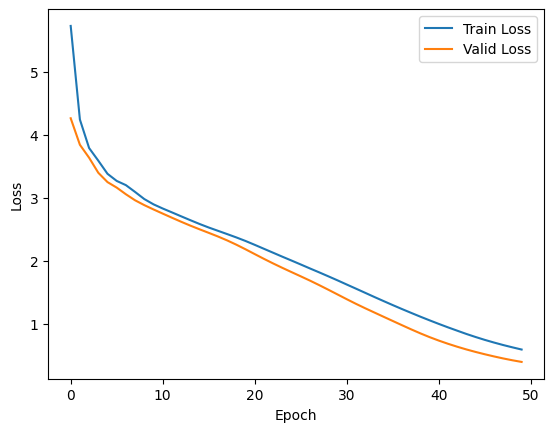

In [13]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##6-2.모델 평가

In [14]:
trained_model = torch.load("/content/drive/MyDrive/Lee/marianmodel_case1_epoch50_traindata45000")
trained_model.eval()

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [52]:
batch = next(iter(valid_dl))
batch

{'input_ids': tensor([[14597, 28541,    48,  ..., 65000, 65000, 65000],
         [    9,  9099,  1815,  ..., 65000, 65000, 65000],
         [  515,  1329,    53,  ..., 65000, 65000, 65000],
         ...,
         [    9, 33909,   500,  ..., 65000, 65000, 65000],
         [  471,  9024, 20092,  ..., 65000, 65000, 65000],
         [    9, 17128,    53,  ..., 65000, 65000, 65000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'decoder_input_ids': tensor([[ 1278, 34239,     4,  ..., 65000, 65000, 65000],
         [  125,  2188,  1673,  ..., 65000, 65000, 65000],
         [   57,   101,    35,  ..., 65000, 65000, 65000],
         ...,
         [   57,  1102,   494,  ..., 65000, 65000, 65000],
         [  158,    10,     4,  ...,  5659,    49,     0],
         [   57,     9,  3166,  ...,  3001,

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_ids = batch['input_ids'].to(device)
input_ids, input_ids.shape

(tensor([[14597, 28541,    48,  ..., 65000, 65000, 65000],
         [    9,  9099,  1815,  ..., 65000, 65000, 65000],
         [  515,  1329,    53,  ..., 65000, 65000, 65000],
         ...,
         [    9, 33909,   500,  ..., 65000, 65000, 65000],
         [  471,  9024, 20092,  ..., 65000, 65000, 65000],
         [    9, 17128,    53,  ..., 65000, 65000, 65000]], device='cuda:0'),
 torch.Size([50, 128]))

In [16]:
translated_ids = trained_model.generate(input_ids, num_beams=2, max_length=128, early_stopping=False)
print(translated_ids), len(translated_ids)

tensor([[65000,    16,    12,  ..., 65000, 65000, 65000],
        [65000,  9750,  6087,  ..., 65000, 65000, 65000],
        [65000,   138,    94,  ...,  2959,  2959,     0],
        ...,
        [65000,    57,   419,  ..., 65000, 65000, 65000],
        [65000,   158,   807,  ...,  2906,  2906,     0],
        [65000,   327,     4,  ...,   350,   350,     0]], device='cuda:0')


(None, 100)

In [17]:
translated_text_list = []
for i in range(len(translated_ids)):
    translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
    translated_text_list.append(translated_text)
    print(f"{i+1}번째 번역 결과:", translated_text)

1번째 번역 결과: I'm finally opening up Elsie tomorrow.
2번째 번역 결과: Sunbaeon, do you know your name?
3번째 번역 결과: In an online video last July, entitled "Syriammmiririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririririr
4번째 번역 결과: As we talked about in the last column, there are a lot of areas in which medication can be helpful, but there are many problems that are not solved with medication.
5번째 번역 결과: The feeling that South Korea is relatively small when it is tied up with China and Japan with the Eastern Festival was not different from this festival.
6번째 번역 결과: The older you get, the more transformational you are.
7번째 번역 결과: It's a 35-dollar gas per hour for Sydney's guided tour.
8번째 번역 결과: A survey of the ‘unreplicititititalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalalal

In [39]:
batch['decoder_input_ids']

tensor([[ 1278, 34239,     4,  ..., 65000, 65000, 65000],
        [  125,  2188,  1673,  ..., 65000, 65000, 65000],
        [   57,   101,    35,  ..., 65000, 65000, 65000],
        ...,
        [   57,  1102,   494,  ..., 65000, 65000, 65000],
        [  158,    10,     4,  ...,  5659,    49,     0],
        [   57,     9,  3166,  ...,  3001,    31,     0]])

In [40]:
answer_translated_text_list = []
for i in range(len(batch['decoder_input_ids'])):
    answer_translated_text = tokenizer.decode(batch['decoder_input_ids'][i], skip_special_tokens=True)
    answer_translated_text_list.append(answer_translated_text)
    print(f"{i+1}번째 정답 결과:", answer_translated_text)

1번째 정답 결과: With the National Pension Service set to introduce the "Stewardship Code" in the second half, companies with no or low propensity to dividend among the companies in which 5% or more of the stake is owned by National Pension Service has emerged as the beneficiaries of the Stewardship Code.
2번째 정답 결과: Heungkuk Life played the first game of the fifth round three days ago and rested for two days, but it didn't seem to have any physical problems.
3번째 정답 결과: There was a scene where she crosses the river on the way to meet the wizard of OZ.
4번째 정답 결과: In the Seoul concert, the blind Jeong Seon-hwa and Myung Chang will sing a pansori to the drumbeat of Cho Kyung-gon, a visually impaired entertainer, who holds the No. 23 (drum and janggu) intangible intangible asset of Incheon City.
5번째 정답 결과: The head of the Gu may choose not to place an advertisement where it is impossible to post the advertisement due to an event of force majeure, such as a natural disaster. In such cases, the hea

###6-3. 단어-단어 accuracy 측정 - train data

In [19]:
# 단어 - 단어로 accuracy 측정

trained_model = torch.load("/content/drive/MyDrive/Lee/marianmodel_case1_epoch50_traindata45000")
trained_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 100
max_length = 128  # 토큰 최대 길이
batch_count = 0   # total_accuracy 계산을 위해 몇 번 배치가 실행되었는지 count
total_batch_accuracy_list = []

for idx, train_batch in enumerate(train_dl):

    input_ids = train_batch['input_ids'].to(device)                                          # 배치 단위의 한글 문장
    translated_ids = trained_model.generate(input_ids, max_length=128, early_stopping=True)  # 배치 단위의 모델 번역 문장
    decoder_input_ids = train_batch['decoder_input_ids']                                     # 배치 단위의 영어 문장(정답)
    one_batch_accuracy_list = []                                                             # 배치 단위의 정확도 리스트

    translated_text_list = []
    target_text_list = []

    for i in range(len(translated_ids)):
        translated_text = tokenizer.decode(translated_ids[i], skip_special_tokens=True)
        translated_text_list.append(translated_text)
        # print(f"{i+1}번째 번역 결과:", translated_text)
    # print(len(translated_text_list))

    for i in range(len(decoder_input_ids)):
        targer_text = tokenizer.decode(decoder_input_ids[i], skip_special_tokens=True)
        target_text_list.append(targer_text)
        # print(f"{i+1}번째 번역 결과:", targer_text)
    # print(target_text_list)


    for i in range(batch_size):

       # 정확도 계산
        correct_count = 0
        if len(translated_text_list[i]) < len(target_text_list[i]):  # 예측 길이 < 정답 길이

            for j in range(len(translated_text_list[i])):
                if translated_text_list[i][j] == target_text_list[i][j]:
                    correct_count += 1

            accuracy_score = correct_count / len(target_text_list[i])


        elif len(translated_text_list[i]) > len(target_text_list[i]):  # 예측 길이 > 정답 길이

            for j in range(len(target_text_list[i])):
                if target_text_list[i][j] == translated_text_list[i][j]:
                    correct_count += 1

            accuracy_score = correct_count / len(translated_text_list[i])


        elif len(translated_text_list[i]) == len(target_text_list[i]):  # 예측 길이 = 정답 길이

            for j in range(len(translated_text_list[i])):
                if translated_text_list[i][j] == target_text_list[i][j]:
                    correct_count += 1

            accuracy_score = correct_count / len(translated_text_list[i])

        else:
            print('ids length error')

        one_batch_accuracy_list.append(accuracy_score)

    # print(len(one_batch_accuracy_list))
    one_batch_accuracy = sum(one_batch_accuracy_list) / batch_size
    # print(one_batch_accuracy)
    # print(f"[{str(idx+1).zfill(2)}번째 배치] 모델 번역 단어와 정답 단어의 정확도: {one_batch_accuracy:.2%}")
    total_batch_accuracy_list.append(one_batch_accuracy)
    # print(len(total_batch_accuracy_list))
    batch_count += 1

# print(batch_count)
total_batch_accuracy = sum(total_batch_accuracy_list) / batch_count
# print(total_batch_accuracy)
print('=================================================================')
print(f"[모든 배치] 모델 번역 단어와 정답 단어의 정확도: {total_batch_accuracy:.2%}")

[모든 배치] 모델 번역 단어와 정답 단어의 정확도: 10.61%
